## Import Libraries

In [114]:
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import random as rand
from scipy.spatial import distance
from deap import base, creator, tools

np.random.seed(3)

%matplotlib inline

## Generate Data

### Generate Cities Layout

In [115]:
num_cities = 21
num_clients = num_cities - 1
num_vehicles = 4
vehicle_payload = 10

In [116]:
# Define the center box within which cities will be generated
center_box = (100, 200)

# Generate random city coordinates using make_blobs function
cities_coord, _ = make_blobs(n_samples = num_cities,
                             centers = 2,
                             cluster_std = 20,
                             center_box = center_box,
                             random_state = 2)

# Create a list of all city names, represented by integers
all_names = [i for i in range(num_cities)]

# Create a list of client city names (excluding the first city)
client_names = [i for i in range(1, num_cities)]

# Create a dictionary mapping all city names to their respective coordinates
all_coord_dict = {name: coord for name, coord in zip(all_names, cities_coord)}

# Create a dictionary mapping client city names to their respective coordinates (excluding the first city)
client_coord_dict = {name: coord for name, coord in zip(client_names, cities_coord[1:])}

### Plot Citites Layout

In [117]:
# Define the size of the plot
plot_size = 15

# Define the width and height of the plot
plot_width = 16
plot_height = 8

# Define a dictionary 'params' containing various plot customization parameters
params = {
    'legend.fontsize': 'large',                   # Set the legend font size to 'large'
    'figure.figsize': (plot_width, plot_height),  # Set the figure size using 'plot_width' and 'plot_height'
    'axes.labelsize': plot_size,                  # Set the label font size for axes
    'axes.titlesize': plot_size,                  # Set the title font size for axes
    'xtick.labelsize': plot_size * 0.75,          # Set the x-axis tick label font size
    'ytick.labelsize': plot_size * 0.75,          # Set the y-axis tick label font size
    'axes.titlepad': 25                           # Set padding for the title of the axes
}

# Update the Matplotlib parameters using the 'params' dictionary
plt.rcParams.update(params)

C:\Users\bianc\AppData\Local\Temp\ipykernel_15584\3374254311.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s = plot_size * 2, cmap='viridis');
C:\Users\bianc\AppData\Local\Temp\ipykernel_15584\3374254311.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s = plot_size * 4, cmap='viridis');


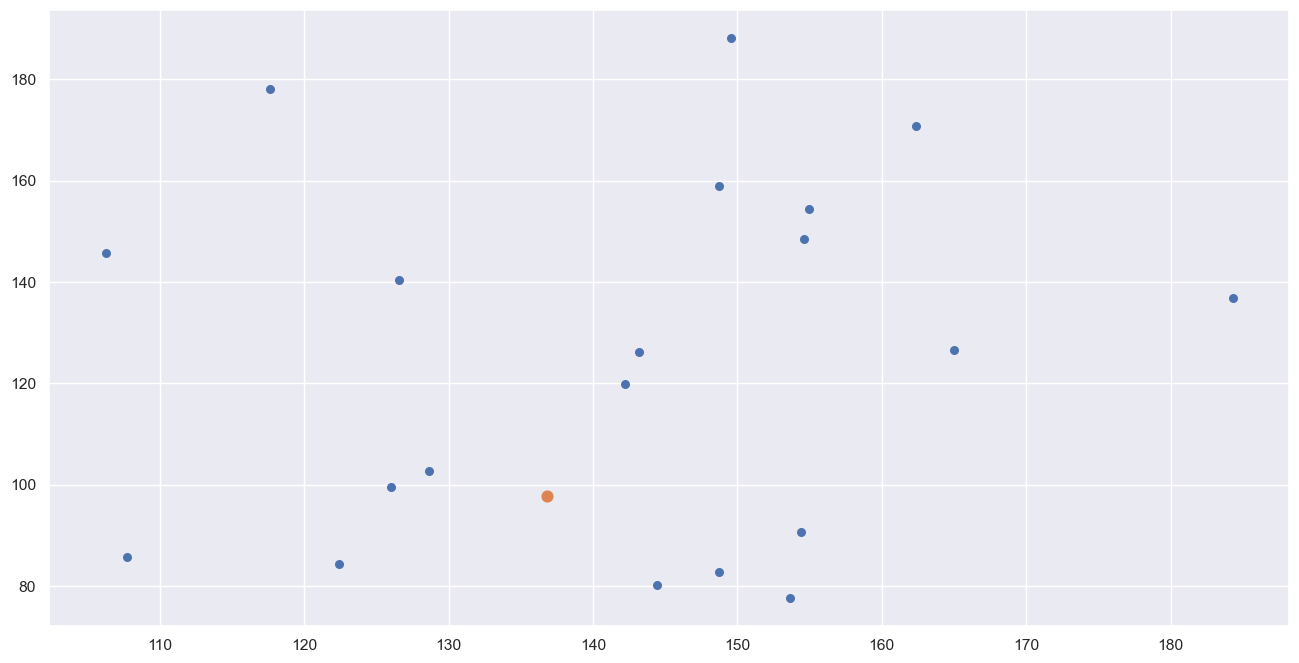

In [118]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s = plot_size * 2, cmap='viridis');
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s = plot_size * 4, cmap='viridis');

### Compute Distance Between Cities

In [119]:
dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')

---

## Define Useful Functions

### Chromosome Creation Function

In [120]:
def chromo_create(_cities_names):
    
    # Create a deep copy of the input list '_cities_names'
    schedule = copy.deepcopy(_cities_names)
    
    # Generate a list of vehicle assignments randomly using integers
    vehicle = list(np.random.randint(num_vehicles, size=(len(schedule))))
    
    # Shuffle the 'schedule' list to randomize the order of visiting cities
    np.random.shuffle(schedule)
    
    # Combine 'schedule' and 'vehicle' into a chromosome
    chromo = [schedule, vehicle]
    
    return chromo

### Chromosome Evaluation Functions

In [121]:
def chromo_eval(_dist_matrix, _chromo):
    
    # Initialize a list 'route_set' to represent routes for each vehicle
    route_set = [[] for _ in range(num_vehicles)]
    
    # Assign cities to their respective routes based on the chromosome
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
        
    # Initialize the total distance 'dist' to 0
    dist = 0
    
    # Calculate the total distance for each route and sum them up
    for route in route_set:
        dist += calc_route_cost(_dist_matrix, route)
        
    return dist,

In [122]:
def get_route(_chromo):
    
    # Initialize a list 'route_set' to represent routes for each vehicle
    route_set = [[] for _ in range(num_vehicles)]
    
    # Assign cities to their respective routes based on the chromosome
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
        
    return route_set

In [123]:
def calc_route_cost(_dist_matrix, _route):
    
    # If the route is empty, the cost is 0
    if not _route:
        return 0
    
    # Initialize the distance 'dist' with the cost of returning to the starting city
    dist = _dist_matrix[_route[-1], 0] + _dist_matrix[0, _route[0]]
    
    # Calculate the distance for the rest of the route and add it to 'dist'
    for p in range(len(_route) - 1):
        _i = _route[p]
        _j = _route[p + 1]
        dist += _dist_matrix[_i][_j]
        
    return dist

### Crossover Functions

In [124]:
def crossover(_chromo1, _chromo2):
    
    # Get the cut positions for chromosome 1 and chromosome 2
    cuts = get_chromo_cut()
    
    # Perform partial crossover on the genes of chromosome 1 and chromosome 2
    partial_crossover(_chromo1[0], _chromo2[0], cuts)
    
    # Get additional cut positions for chromosome 1 and chromosome 2
    cuts1 = get_chromo_cut()
    cuts2 = get_chromo_cut(cuts1[2])
    
    # Swap genes between chromosome 1 and chromosome 2
    swap_genes(_chromo1[1], _chromo2[1], cuts1, cuts2)

In [125]:
def partial_crossover(_chromo1, _chromo2, cuts):
    
    size = len(_chromo1)
    p1, p2 = [0] * size, [0] * size
    
    # Create position dictionaries for genes in chromosome 1 and chromosome 2
    for i in range(size):
        p1[_chromo1[i] - 1] = i
        p2[_chromo2[i] - 1] = i
        
    # Perform partial crossover between the cut points
    for i in range(cuts[0], cuts[1]):

        temp1 = _chromo1[i] - 1
        temp2 = _chromo2[i] - 1

        _chromo1[i], _chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

In [126]:
def get_chromo_cut(cut_range=None, mutation=False):

    # Define the range for generating cut positions based on whether it's a mutation
    if mutation:
        randrange = num_clients
    else:
        randrange = num_clients + 1

    # Generate random cut positions within the specified range
    if cut_range is None:
        cut1 = rand.randrange(randrange)
        cut2 = rand.randrange(randrange)
        if cut1 > cut2:
            tmp = cut2
            cut2 = cut1
            cut1 = tmp
        cut_range = cut2 - cut1
    else:
        cut1 = rand.randrange(num_clients + 1 - cut_range)
        cut2 = cut1 + cut_range
    
    return cut1, cut2, cut_range

In [127]:
def swap_genes(chrom1, chrom2, cuts1, cuts2):
    tmp = chrom1[cuts1[0]:cuts1[1]]
    chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
    chrom2[cuts2[0]:cuts2[1]] = tmp

### Mutation Functions

In [128]:
def mutation(_chromo):
    # Randomly choose between swap_gene and shuffle_gene mutations
    if np.random.rand() < 0.5:
        swap_gene(_chromo)
    else:
        shuffle_gene(_chromo)

In [129]:
def swap_gene(_chromo):
    # Get cut positions for the mutation operation
    cuts = get_chromo_cut(mutation=True)

    # Randomly choose whether to swap genes within the schedule or the vehicle assignment
    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]]
        _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
        _chromo[0][cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]]
        _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
        _chromo[1][cuts[1]] = tmp      

In [130]:
def shuffle_gene(_chromo):
    # Get cut positions for the mutation operation
    cuts = get_chromo_cut(mutation=True)

    # Randomly choose whether to shuffle genes within the schedule or the vehicle assignment
    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[0][cuts[0]:cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[1][cuts[0]:cuts[1]] = tmp

### Feasability

In [131]:
def feasibility(_chromo):
    # Calculate the excess payload for each vehicle by counting the number of assignments
    excess_payload = [vehicle_payload - _chromo[1].count(i) for i in range(num_vehicles)]
    
    # Create a list '_vehicle_id' to represent the IDs of vehicles
    _vehicle_id = [i for i in range(num_vehicles)]

    # Continue until there is no excess payload for any vehicle
    while any(_p < 0 for _p in excess_payload):
        # Find the first vehicle with excess payload (negative payload)
        v_id = next(i for i, _p in enumerate(excess_payload) if _p < 0)
        
        # Find available vehicles that can accept excess cargo
        available_vehicles = [i for i, e in enumerate(excess_payload) if e > 0]
        
        # If no available vehicles can accept excess cargo, raise an exception
        if len(available_vehicles) == 0:
            raise Exception('INFEASIBLE SOLUTION: No available vehicle to accept excess cargo. Increase the number of vehicles or the vehicle payload')
        
        # Choose an index from the chromosome where the vehicle assignment needs to be changed
        idx = [i for i, x in enumerate(_chromo[1]) if x == v_id]
        
        # Choose a vehicle to move the cargo to
        to_vehicle = rand.choice(available_vehicles)
        
        # Choose an index from the selected vehicle to move the cargo
        idx_to_move = rand.choice(idx)
        
        # Update the chromosome to move cargo from 'v_id' to 'to_vehicle'
        _chromo[1][idx_to_move] = to_vehicle
        
        # Update the excess payload for both vehicles
        excess_payload[v_id] += 1
        excess_payload[to_vehicle] -= 1

---

## Solve VRO w/ Genetic Algorithms (DEAP)

### Setup Genetic Algorithm Parameters

In [132]:
# Create a toolbox 'tb' for defining genetic algorithm components
tb = base.Toolbox()

# Define a fitness function class 'Fitness_Func' with a single objective (-1.0 for minimization)
creator.create('Fitness_Func', base.Fitness, weights=(-1.0,))

# Define an individual class 'Individual' as a list with the 'Fitness_Func' assigned as its fitness attribute
creator.create('Individual', list, fitness=creator.Fitness_Func)

In [133]:
num_population = 200
num_generations = 1000
prob_crossover = .4
prob_mutation = .6

In [134]:
# Register 'indexes' function, which creates a chromosome, with the client names
tb.register('indexes', chromo_create, client_names)

# Register 'individual' function to initialize individuals using 'initIterate' with 'creator.Individual' and 'tb.indexes'
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)

# Register 'population' function to initialize a population using 'initRepeat' with 'list' and 'tb.individual'
tb.register('population', tools.initRepeat, list, tb.individual)

# Register 'evaluate' function to evaluate individuals using the 'chromo_eval' function and 'dist_matrix'
tb.register('evaluate', chromo_eval, dist_matrix)

# Register 'select' function for tournament selection using 'selTournament'
tb.register('select', tools.selTournament)

# Register 'mate' function for crossover operation
tb.register('mate', crossover)

# Register 'mutate' function for mutation operation
tb.register('mutate', mutation)

# Register 'feasibility' function for checking the feasibility of individuals
tb.register('feasibility', feasibility)

### Create Initial Population

In [135]:
population = tb.population(n=num_population)

### Calculate Fitness of All Chromosomoes in the Population

In [136]:
# Calculate the fitness values for the entire population using the 'evaluate' function registered in the toolbox
fitness_set = list(tb.map(tb.evaluate, population))

# Assign the calculated fitness values to the individuals in the population
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

### Selection, Crossover and Mutation

In [137]:
# Initialize lists to store the best fitness and solutions over generations
best_fit_list = [] # List to store the best fitness values
best_sol_list = [] # List to store the best solutions (individuals)

# Initialize the best fitness with positive infinity to ensure any initial solution is better
best_fit = np.Inf

# Start measuring time
start = time.time()

for gen in range(0, num_generations):
    
    # Print the generation number and best fitness every 50 generations
    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' )
    
    # Select parents for reproduction using tournament selection
    offspring = tb.select(population, len(population), tournsize=3)
    offspring = list(map(tb.clone, offspring))
    
    # Apply crossover to pairs of offspring with a certain probability
    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation to offspring with a certain probability
    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo)
            del chromo.fitness.values
            
    # Check the feasibility of offspring solutions
    for chromo in offspring:
        tb.feasibility(chromo)

    # Identify individuals that need evaluation (fitness is not valid)
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    
    # Evaluate the fitness for the invalid individuals
    fitness_set = map(tb.evaluate, invalid_ind)
    
    # Assign fitness values to the evaluated individuals
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit
    
    # Replace the current population with the offspring population
    population[:] = offspring
    
    # Select the current best solution (individual) and its fitness
    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]
    
    # Update the best solution and best fitness if a better solution is found
    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    # Append the best fitness and best solution to their respective lists
    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)
    
# Stop measuring time
stop = time.time()

Generation:    0 | Fitness: inf
Generation:   50 | Fitness: 652.46
Generation:  100 | Fitness: 566.87
Generation:  150 | Fitness: 549.02
Generation:  200 | Fitness: 536.10
Generation:  250 | Fitness: 536.10
Generation:  300 | Fitness: 536.10
Generation:  350 | Fitness: 506.03
Generation:  400 | Fitness: 501.78
Generation:  450 | Fitness: 501.78
Generation:  500 | Fitness: 490.45
Generation:  550 | Fitness: 485.60
Generation:  600 | Fitness: 470.28
Generation:  650 | Fitness: 470.19
Generation:  700 | Fitness: 470.19
Generation:  750 | Fitness: 470.19
Generation:  800 | Fitness: 467.23
Generation:  850 | Fitness: 463.72
Generation:  900 | Fitness: 463.72
Generation:  950 | Fitness: 463.72


### Plot Fitness for Generation

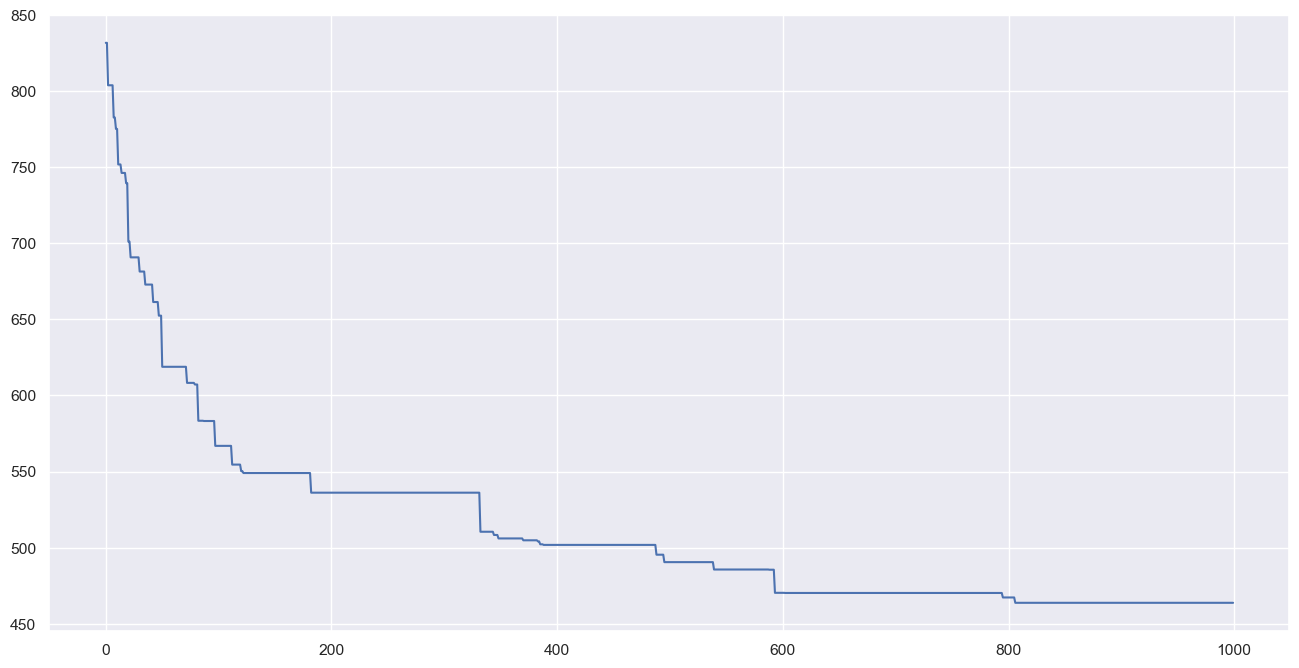

In [141]:
plt.plot(best_fit_list)
plt.show()

## Solution

In [142]:
best_routes = get_route(best_sol)
print(best_routes)

print(f"Best solution: {best_routes}")
print(f"Execution time: {round((stop - start), 2)} seconds")

[[8, 1, 15, 4, 19, 3], [11, 16, 17, 20], [2, 9, 18, 13, 6, 12, 14, 5, 10, 7], []]
Best solution: [[8, 1, 15, 4, 19, 3], [11, 16, 17, 20], [2, 9, 18, 13, 6, 12, 14, 5, 10, 7], []]
Execution time: 61.44 seconds


C:\Users\bianc\AppData\Local\Temp\ipykernel_15584\3097753406.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis')  # Plot client cities
C:\Users\bianc\AppData\Local\Temp\ipykernel_15584\3097753406.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis')    # Plot depot city


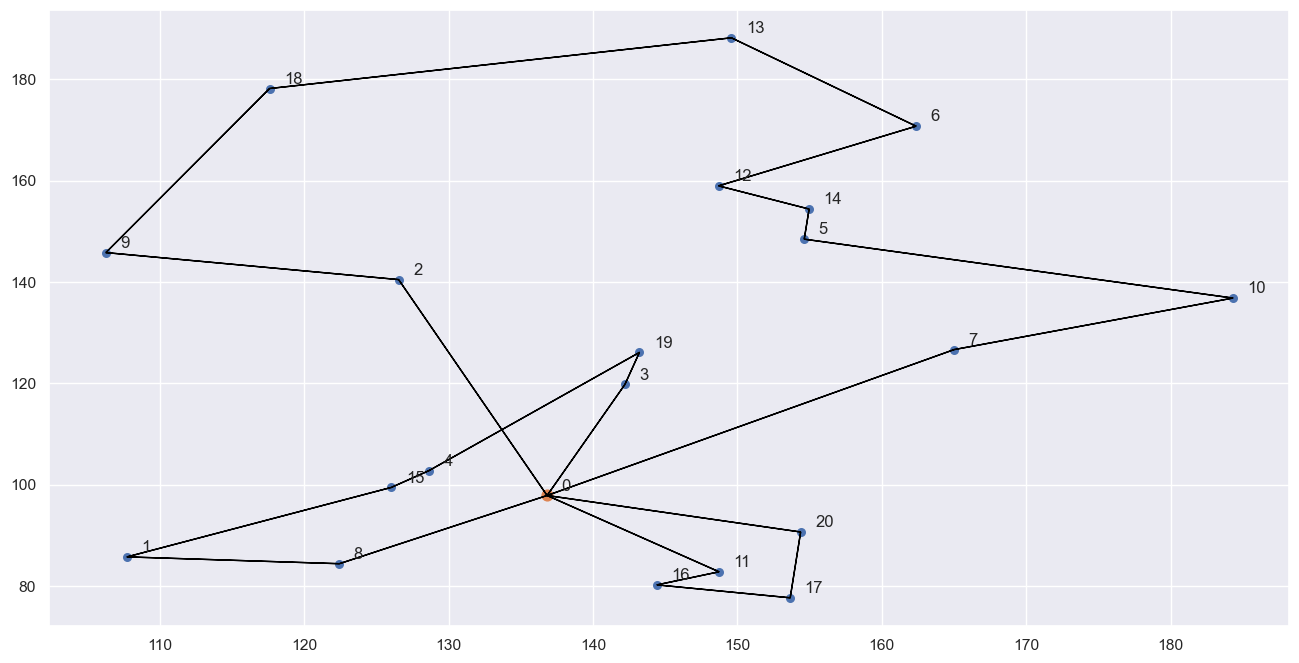

In [143]:
# Scatter plot of cities with different markers and labels
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis')  # Plot client cities
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis')    # Plot depot city
for i, txt in enumerate(all_names):
    plt.annotate(txt, (cities_coord[i, 0]+1, cities_coord[i, 1]+1))  # Annotate cities with labels

# Plot the best routes
for r in best_routes:
    route = [0] + r + [0]  # Add the depot city to the beginning and end of the route
    for p in range(len(route) - 1):
        i = route[p]
        j = route[p + 1]
        colour = 'black'  # Define arrow color
        
        # Draw an arrow from city i to city j
        plt.arrow(cities_coord[i][0],
                  cities_coord[i][1],
                  cities_coord[j][0] - cities_coord[i][0],
                  cities_coord[j][1] - cities_coord[i][1],
                  color=colour)

# Display the plot
plt.show()